In [194]:
import os
import xml.etree.ElementTree as ET
import albumentations as A
from albumentations.pytorch import ToTensorV2
import random
from PIL import Image, ImageDraw
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, random_split, Subset
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from torchvision.ops import nms
import torchvision.transforms as T
import torchvision
import pandas as pd
import cv2
import json

In [195]:
root_path = '.\\dumpsite_data\\VOC2012'
train_path = os.path.join(root_path, "train")
test_path = os.path.join(root_path, "test")
file_Annotations = os.path.join(train_path, "Annotations")

In [196]:
object_class = []
for each_xml in os.listdir(file_Annotations):
    pic_xml = os.path.join(file_Annotations, each_xml)
    tree = ET.parse(pic_xml)
    root = tree.getroot()
    for object_elem in root.findall('object'):
        name_elem_value = object_elem.find('name').text
        object_class.append(name_elem_value)
classes = set(object_class)
print(classes)


{'domestic garbage', 'agriculture forestry', 'construction waste', 'disposed garbage', 'mining waste', 'industry waste'}


In [197]:
# label_maps = {}
# for index, class_name in enumerate(classes):
#     label_maps[class_name] = index
# print(label_maps)

In [198]:
# with open('label_maps.json', 'w') as json_file:
#     json.dump(label_maps, json_file)

In [199]:
with open('label_maps.json', 'r') as json_file:
    label_maps = json.load(json_file)

In [200]:
for index, class_name in enumerate(object_class):
    object_class[index] = label_maps[class_name]
classes_counts = np.bincount(object_class)
classes_weights = 1. / classes_counts
sample_weights = classes_weights[object_class]

In [201]:
df = pd.Series(data=classes_counts.flatten(), index=list(classes))
df

domestic garbage        2301
agriculture forestry     247
construction waste       581
disposed garbage           9
mining waste               1
industry waste             1
dtype: int64

Text(0.5, 1.0, 'the count number of labels')

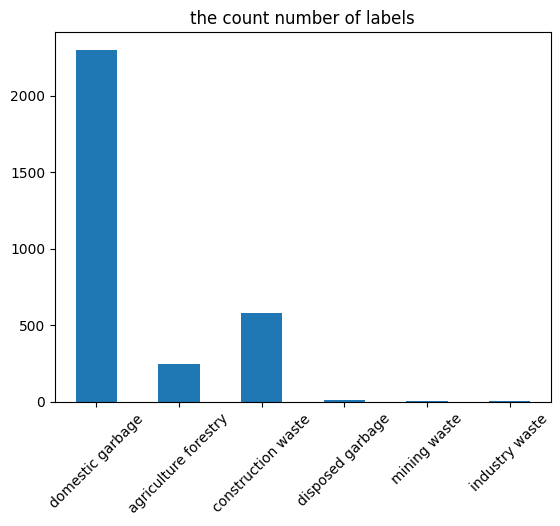

In [202]:
df.plot.bar(rot=45)
plt.title("the count number of labels")

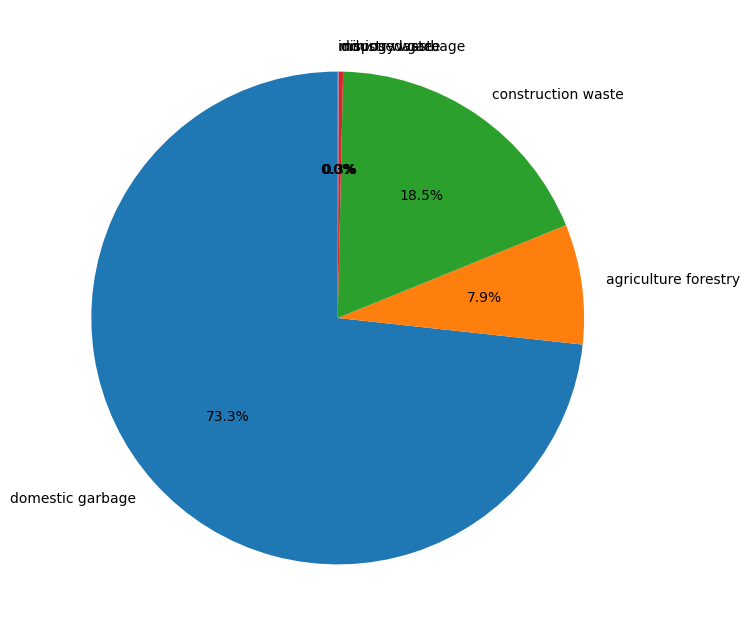

In [203]:
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(classes_counts.flatten(), labels=classes, autopct='%1.1f%%', startangle=90)
for text in texts:
    text.set_fontsize(10)
    text.set_color('black')
for autotext in autotexts:
    autotext.set_fontsize(10)
    autotext.set_color('black')
plt.show()

In [204]:
def label_name(label_num):
    class_name = {k for k, v in label_maps.items() if v == label_num}
    return list(class_name)[0]

##### Due to the problem of severe sample imbalance in the dumpsite dataset (Fig. 1a), we propose two training strategies, data augmentation (vertical flipping, horizontal
##### flipping, forward 90° rotation and reverse 90° rotation) and category balancing, to ensure the model’sefficiency during the training process

In [205]:
class Customdataset(Subset):
    def __init__(self, dataset, indices):
        super().__init__(dataset, indices)
        self.dataset = dataset
        self.indices = indices
        
    def compare_pic(self, idx=None):
        if idx is None:
            random_idx = random.randint(0, len(self.indices) - 1)
        else:
            random_idx = idx
        original_idx = self.indices[random_idx]
        self.dataset.compare_pic(original_idx)
    
    def load_annotations(self):
        annotations = [self.dataset.load_annotations()[i] for i in self.indices]
        return annotations

In [206]:
class  VOCDataset(Dataset):
    """
    The VOCDataset will attempt to load the dataset of the Pascal VOC format
    """
    def __init__(self, root, transforms, mode):
        self.root = root
        self.transforms = transforms
        if mode == "train":
            txt_file = os.path.join(root, "train.txt")
            self.status = "train"
        elif mode == "val":
            txt_file = os.path.join(root, "train.txt")
            self.status = "val"
        else:
            txt_file = os.path.join(root, "test.txt")
            self.status = "test"
        with open(txt_file, 'r') as f:
            self.image_ids = f.read().strip().split()
        self.image_folder = os.path.join(root, "JPEGImages")
        self.ann_folder = os.path.join(root, "Annotations")

    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        """
        The __getitem__ function will attempt to load the specific image after pre-processing
        Args:
            idx (int) : the index of the image
        Returns:
            dict : image, boxes, labels
        """
        img_id = self.image_ids[idx]
        img_path = os.path.join(self.image_folder, f"{img_id}.jpg")
        ann_path = os.path.join(self.ann_folder, f"{img_id}.xml")

        img = np.array(Image.open(img_path).convert("RGB"))
        tree = ET.parse(ann_path)
        root = tree.getroot()
        boxes = []
        labels = []
        for obj in root.findall("object"):
            label = obj.find("name").text
            labels.append(label_maps[label])
            bbox = obj.find("bndbox")
            xmin = int(bbox.find("xmin").text)
            ymin = int(bbox.find("ymin").text)
            xmax = int(bbox.find("xmax").text)
            ymax = int(bbox.find("ymax").text)
            box = [xmin, ymin, xmax, ymax]
            boxes.append(box)
        
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        target = {"boxes":boxes, "labels":labels}
        # print("转换前：", target['boxes'], target['labels'])
        if self.status == "train":
            while True:
                img_copy, target_copy = img.copy(), target.copy()
                transformed = self.transforms(image=img_copy, bboxes=target_copy['boxes'].tolist(), labels=target_copy['labels'].tolist())
                img_copy = transformed['image']
                target_copy['boxes'] = torch.tensor(transformed['bboxes'], dtype=torch.float32)
                target_copy['labels'] = torch.tensor(transformed['labels'], dtype=torch.int64)
                # print("转换后：", target_copy['boxes'], target_copy['labels'])
                if torch.numel(target_copy['boxes']) > 0:
                    img, target = img_copy, target_copy
                    break
        else:
            img = self.transforms(img)
        return {'image':img, 'boxes':target['boxes'], 'labels':target['labels']}

    def _unnormalize(self, image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        """
        _unnormalize function will attempt to recover the image which has been normalized.
        Args:
            image (torch) : the image would be unnormalized.
            mean (torch) : the default mean value.
            std (torch) : the default std value.
        Returns:
            torch : the unnormalized image
        """
        mean = torch.tensor(mean)[:, None, None]
        std = torch.tensor(std)[:, None, None]
        return image * std + mean

    # judge if the bounding box is in the image
    def _clip_boxes(self, boxes, img_shape):
        """
        _clip_boxes will attempy to check if the bounding box is out of borader.
        Args:
            boxes (numpy) : the position of the bounding box.
            img_shape : the size of the border.
        Returns:
            numpy : the qualified bounding box
        """
        boxes[:, 0].clamp_(min=0, max=img_shape[0])
        boxes[:, 1].clamp_(min=0, max=img_shape[1])
        boxes[:, 2].clamp_(min=0, max=img_shape[0])
        boxes[:, 3].clamp_(min=0, max=img_shape[1])
        return boxes
    
    def _check_bounding_box(self, boxes):
        """
        _check_bounding_box will attempt to check if the bounding box statisfy the xmin < xmax, ymin < ymax, to make sure there will be a region
        Args:
            boxes (numpy) : the position of the bounding box.
        Returns:
            bool : if the bounding box is a region instead of a line.
        """
        if boxes.ndim == 1:
            boxes = boxes.unsqueeze(0)
        condition_x = boxes[:, 0] < boxes[:, 2]
        condition_y = boxes[:, 1] < boxes[:, 3]
        condition = condition_x & condition_y
        return torch.all(condition).item()

    def compare_pic(self, idx=None):
        """
        compare_pic will attempt to show the original image and the image after pre-processing through visualization.
        Args:
            idx (int) : random image or a specific image.
        Returns:
            plots : two plots.
        """
        if idx == None:
            random_idx = random.randint(0, len(self.image_ids) - 1)
        else:
            random_idx = idx
        
        if self.status == "train":
            ori_pic = os.path.join("./dumpsite_data/VOC2012/train/JPEGImages", f'{self.image_ids[random_idx]}.jpg')
            ori_pic_ann = os.path.join("./dumpsite_data/VOC2012/train/Annotations", f"{self.image_ids[random_idx]}.xml")
        else:
            ori_pic = os.path.join("./dumpsite_data/VOC2012/test/JPEGImages", f'{self.image_ids[random_idx]}.jpg')
            ori_pic_ann = os.path.join("./dumpsite_data/VOC2012/test/Annotations", f"{self.image_ids[random_idx]}.xml")
        ori_pic = Image.open(ori_pic).convert("RGB")
        tree = ET.parse(ori_pic_ann)
        root = tree.getroot()
        ori_boxes = []
        ori_labels = []
        for bounding_box in root.findall('object'):
            label = bounding_box.find("name").text
            ori_labels.append(label)
            bbox = bounding_box.find("bndbox")
            xmin = int(bbox.find("xmin").text)
            ymin = int(bbox.find("ymin").text)
            xmax = int(bbox.find("xmax").text)
            ymax = int(bbox.find("ymax").text)
            box = [xmin, ymin, xmax, ymax]
            ori_boxes.append(box)
        ori_draw = ImageDraw.Draw(ori_pic)
        for box, label in zip(ori_boxes, ori_labels):
            xmin, ymin, xmax, ymax = box
            ori_draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=10)
            ori_draw.text((xmin - 10, ymin - 10), label, fill="red")
            
        sample = self[random_idx]
        if sample:
            image, boxes, labels = sample['image'], sample['boxes'], sample['labels']
            image = self._unnormalize(image).permute(1, 2, 0).numpy()
            image = (image * 255).astype(np.uint8)
            image = F.to_pil_image(image)
            draw = ImageDraw.Draw(image)
            for box, label in zip(boxes, labels):
                xmin, ymin, xmax, ymax = box
                draw.rectangle([xmin, ymin, xmax, ymax], outline="black", width=10)
                draw.text((xmin - 10, ymin - 10), label_name(label), fill="black")

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
            ax1.imshow(ori_pic)
            ax1.set_title('ori_pic')
            ax2.imshow(image)
            ax2.set_title('after_pic')
            plt.show()

    def load_annotations(self):
        """
        load_annotations function attempt to store the classes appeared in each image to recompute the image weight
        Returns:
            list : the labels in each image
        """
        data_infos = []
        for index in self.image_ids:
            ann_path = os.path.join(self.ann_folder, f"{index}.xml")
            tree = ET.parse(ann_path)
            root = tree.getroot()
            temp_labels = []
            for obj in root.findall("object"):
                label = obj.find("name").text
                temp_labels.append(label_maps[label])
            data_infos.append(temp_labels)
        return data_infos

In [207]:
transform = {
    "train" : A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=90, p=0.5),
    A.Rotate(limit=-90, p=0.5), 
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])),
    "test" : T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
}

In [208]:
def collate_fn(batch):
    images = []
    targets = []
    for obj in batch:
        if obj:
            images.append(obj['image'])
            targets.append({'boxes':obj['boxes'], 'labels':obj['labels']})
    images = torch.stack(images, dim=0)
    return images, targets


# transforms = DetectionTransforms()
train_dataset = VOCDataset(root='./dumpsite_data/VOC2012/train', transforms=transform["train"], mode="train")
val_dataset = VOCDataset(root='./dumpsite_data/VOC2012/train', transforms=transform["test"], mode="val")

In [209]:
validation_split = 0.2
dataset_size = len(train_dataset)
validation_size = int(validation_split * dataset_size)
train_size = dataset_size - validation_size

In [210]:
train_indices, val_indices = random_split(range(dataset_size), [train_size, validation_size])

In [211]:
train_subset = Customdataset(train_dataset, train_indices)
val_subset = Customdataset(val_dataset, val_indices)

In [212]:
annotations = train_dataset.load_annotations()
image_weights = []
for img_classes in annotations:
    img_weight = np.mean([classes_weights[cls] for cls in img_classes])
    image_weights.append(img_weight)

In [213]:
train_image_weights = [image_weights[i] for i in train_subset.indices]
sampler = WeightedRandomSampler(weights=train_image_weights, num_samples=len(train_image_weights), replacement=True)
train_dataloader = DataLoader(train_subset, batch_size=8, collate_fn=collate_fn, sampler=sampler)
val_dataloader = DataLoader(val_subset, batch_size=8, collate_fn=collate_fn)
test_dataset = VOCDataset(root='./dumpsite_data/VOC2012/test', transforms=transform["test"], mode="test")
test_dataloader = DataLoader(test_dataset, batch_size=8, collate_fn=collate_fn)

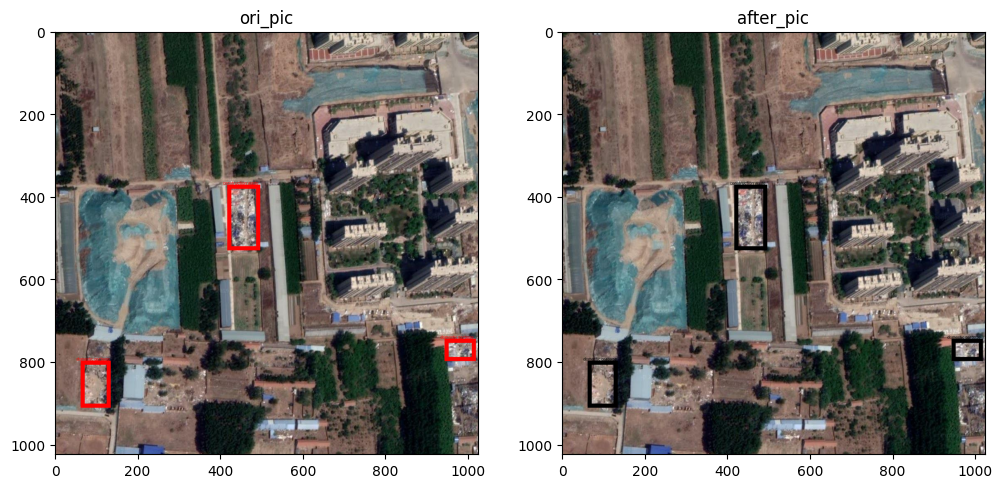

In [214]:
test_dataset.compare_pic(32)

#### 原图与处理后的图片对比（含有边框）

In [215]:
# num_classes = 6
# model = fasterrcnn_resnet50_fpn(pretrained=True)
# input_features = model.roi_heads.box_predictor.cls_score.in_features
# model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(input_features, num_classes=num_classes)

In [216]:
class BCA_NET(torch.nn.Module):
    def __init__(self, in_channels, alpha=2, units=256):
        super(BCA_NET, self).__init__()
        self.in_channels = in_channels
        self.alpha = alpha
        self.units = units
        self.avg_pool = torch.nn.AdaptiveAvgPool2d((in_channels // alpha, in_channels // alpha))
        self.fc1 = torch.nn.Linear(in_channels // alpha * (in_channels // alpha), units)
        self.fc2 = torch.nn.Linear(units, in_channels // alpha * (in_channels // alpha))
        self.sigmoid = torch.nn.Sigmoid()
        self.relu = torch.nn.functional.relu()
        self.upsample = torch.nn.Upsample(scale_factor=alpha, mode="nearest")
    
    def forward(self, x):
        batch_size, channels, H, W = x.size()
        y = self.avg_pool(x)
        y = y.view(batch_size, -1)
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y)
        y = y.view(batch_size, channels, H // self.alpha, W // self.alpha)
        y = self.upsample(y)
        out = x * y
        return out

In [ ]:
def decode_output(output, threshold):
    """
    decode_output function attempts to change the tensor into the numpy format and save the boxes and relative label which has high confidence by NMS
    Args:
        output : the output of the fastrcnn_model {boxes, labels, scores}
    Returns:
        list : boxes, list : scores(confidence), list : labels
    """
    boxes = output["boxes"].cpu().detach().numpy().astype(np.float32)
    labels = np.array([label_name(i) for i in output["labels"].cpu().detach().numpy()])
    scores = output["scores"].cpu().detach().numpy()
    indexes = nms(torch.tensor(boxes), torch.tensor(scores), threshold)
    boxes, scores, labels = [tensor[indexes] for tensor in [boxes, labels, scores]]

    return boxes.tolist(), scores.tolist(), labels.tolist()

In [ ]:
def plot_boxes_scores_labels(image, boxes, scores, labels, label_color=None):
    """
    Plot bounding boxes, confidence scores, and labels on an image.
    
    Parameters:
      image: The image on which to plot (numpy array).
      bbs: List of bounding boxes, each in the form [x, y, width, height].
      confs: List of confidence scores for each bounding box.
      labels: List of labels for each bounding box.
      label_colors: Optional dictionary mapping labels to colors.
    
    Returns:
      Image with bounding boxes, confidence scores, and labels plotted.
    """
    image_copy = image.copy()

    if label_color is None:
        label_color = {}
    
    for box, score, label in zip(boxes, scores, labels):
        x_min, y_min, x_max, y_max = box
        color = label_color.get(label, (0, 255, 0))
        cv2.rectangle(image_copy, (x_min, y_min), (x_max - x_min, y_max - y_min). color, 2)
        text = f"{label}, {score:.2f}"
        (text_width, text_height), baseline = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        cv2.rectangle(image_copy, (x_min, y_min), (x_min + text_width, y_min - text_height - baseline), color, cv2.FILLED)
        cv2.putText(image_copy, text, (x_min, y_min - baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    
    return image_copy

## train part

In [217]:
model = fasterrcnn_resnet50_fpn(pretrained=False)
checkpoint_path = './fasterrcnn_resnet50_fpn.pth'
model.load_state_dict(torch.load(checkpoint_path))
num_classes = 6
input_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(input_features, num_classes=num_classes)

c:\Users\learn\.conda\envs\pytorch_comp9444\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\learn\.conda\envs\pytorch_comp9444\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [218]:
for param in model.parameters():
    param.requires_grad = False
for param in model.roi_heads.box_predictor.parameters():
    param.requires_grad = True
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params=params, lr=0.0025, momentum=0.9, weight_decay=0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=3, gamma=0.1)

In [219]:
epochs = 3
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
model.to(device)
model.train()
train_loss_epochs = []
val_loss_epochs = []
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
best_valid_loss = float("inf")

In [ ]:
for epoch in range(epochs):
    model.train()
    train_loss_epoch = []
    for images, targets in train_dataloader:
        images = list(image.to(device) for image in images)
        filtered_images = []
        filtered_targets = []
        for image, target in zip(images, targets):
            # if target['boxes'].numel() > 0:
            filtered_images.append(image)
            filtered_targets.append({box: label.to(device) for box, label in target.items()})
        
        # if len(filtered_targets) == 0:
        #     continue
        optimizer.zero_grad()
        loss = model(filtered_images, filtered_targets)
        losses = sum(loss for loss in loss.values())
        losses.backward()
        optimizer.step()
        train_loss_epoch.append(losses.item())
    train_loss_epochs.append(np.mean(train_loss_epoch))
    lr_scheduler.step()

    model.train()
    val_loss_epoch = []
    with torch.no_grad():
        for images, targets in val_dataloader:
            images_list = []
            targets_list = []
            images = list(image.to(device) for image in images)
            for image, target in zip(images, targets):
                images_list.append(image)
                targets_list.append({box: label.to(device) for box, label in target.items()})

            output = model(images_list, targets_list)
            val_losses = sum(loss for loss in output.values())
            val_loss_epoch.append(val_losses.item())
        val_losses = np.mean(val_loss_epoch)
        if val_losses < best_valid_loss:
                best_valid_loss = val_losses
                torch.save({
                        'epoch' : epoch,
                        'model_state_dict' : model.state_dict(),
                        'optimizer_state_dict' : optimizer.state_dict(),
                        'lr_scheduler_state_dict' : lr_scheduler.state_dict(),
                        'loss' : losses.item(),}, f"final_model.pth")
        print(val_losses)
        val_loss_epochs.append(val_losses)

    # 通过比较metrics保存模型部分, 各位按照各自代码完成

    checkpoint_path = f"model_epoch_{epoch + 1}.pth"
    torch.save({
        'epoch' : epoch,
        'model_state_dict' : model.state_dict(),
        'optimizer_state_dict' : optimizer.state_dict(),
        'lr_scheduler_state_dict' : lr_scheduler.state_dict(),
        'loss' : losses.item(),
    }, checkpoint_path)



## test part

In [ ]:
model.eval()
for idx, (images, targets) in enumerate(test_dataloader):
    outputs = model(images)
    for index, output in enumerate(outputs):
        boxes, scores, labels = decode_output(output)
        image = plot_boxes_scores_labels(images[index].cpu().permute(1, 2, 0).numpy(), boxes, scores, labels)
        plt.imshow(image)
        plt.axis("off")
        plt.show()

In [ ]:
model_path = torch.load("final_model.pth")
model.load_state_dict(model_path['model_state_dict'])
model.to(device)

[0.13687076 0.07806459 0.0584773  0.0555852 ]


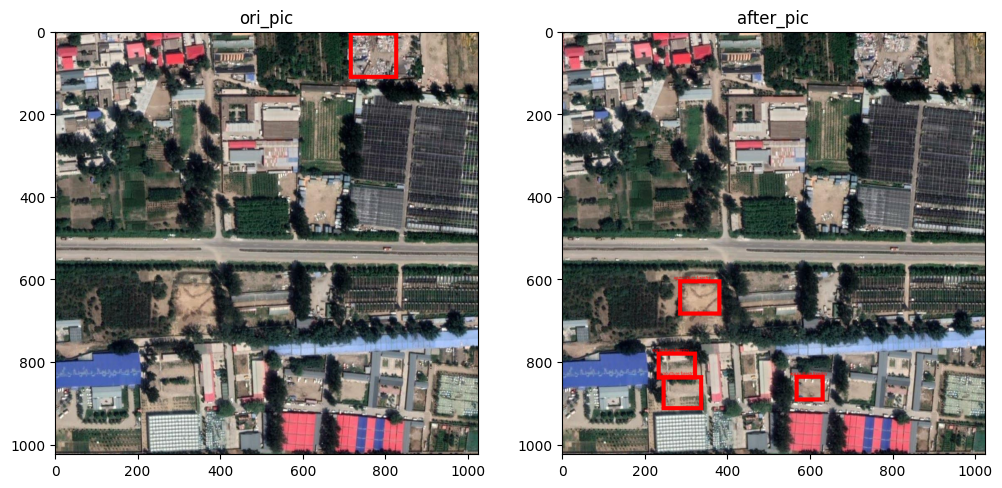

In [ ]:
# model.eval()
# with torch.no_grad():
#     img_PIL = Image.open(".\\dumpsite_data\\VOC2012\\test\\JPEGImages\\40077.jpg").convert("RGB")
#     tree = ET.parse(".\\dumpsite_data\\VOC2012\\test\\Annotations\\40077.xml")
#     root = tree.getroot()
#     ori_boxes = []
#     ori_labels = []
#     for bounding_box in root.findall('object'):
#         label = bounding_box.find("name").text
#         ori_labels.append(label)
#         bbox = bounding_box.find("bndbox")
#         xmin = int(bbox.find("xmin").text)
#         ymin = int(bbox.find("ymin").text)
#         xmax = int(bbox.find("xmax").text)
#         ymax = int(bbox.find("ymax").text)
#         box = [xmin, ymin, xmax, ymax]
#         ori_boxes.append(box)
#     img_PIL_copy = img_PIL.copy()
#     ori_draw = ImageDraw.Draw(img_PIL_copy)
#     for box, label in zip(ori_boxes, ori_labels):
#         xmin, ymin, xmax, ymax = box
#         ori_draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=10)
#         ori_draw.text((xmin - 10, ymin - 10), label, fill="red")
        
#     img = test_transform(img_PIL)
#     img = img[None].to(device)
#     output = model(img)
#     boxes = output[0]['boxes'].cpu().numpy()
#     labels = output[0]['labels'].cpu().numpy()
#     scores = output[0]['scores'].cpu().numpy()
#     draw = ImageDraw.Draw(img_PIL)
#     for box, label in zip(boxes, labels):
#         xmin, ymin, xmax, ymax = box
#         draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=10)
#         draw.text((xmin - 10, ymin - 10), label_name(label), fill="red")
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
#     ax1.imshow(img_PIL_copy)
#     ax1.set_title('ori_pic')
#     ax2.imshow(img_PIL)
#     ax2.set_title('after_pic')
#     print(scores)
#     plt.show()


## resnet_model_test 部分